<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LightGBM</a></span><ul class="toc-item"><li><span><a href="#Benchmarking" data-toc-modified-id="Benchmarking-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Benchmarking</a></span></li><li><span><a href="#Categorical-Variables-in-Tree-based-Models" data-toc-modified-id="Categorical-Variables-in-Tree-based-Models-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Categorical Variables in Tree-based Models</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(css_style = 'custom2.css', plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlutils.transformers import Preprocessor

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,xgboost,lightgbm

Ethen 2019-02-23 23:46:25 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
pandas 0.23.4
sklearn 0.20.2
matplotlib 2.2.3
xgboost 0.81
lightgbm 2.2.4


# LightGBM

[Gradient boosting](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/gbm/gbm.ipynb) is a machine learning technique that produces a prediction model in the form of an ensemble of weak classifiers, optimizing for a differentiable loss function. One of the most popular types of gradient boosting is gradient boosted trees, that internally is made up of an ensemble of week [decision trees](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/decision_tree.ipynb). There are two different ways to compute the trees: level-wise and leaf-wise as illustrated by the diagram below:

<img src="img/levelwise.png" width="50%" height="50%">

<img src="img/leafwise.png" width="60%" height="60%">

> The level-wise strategy adds complexity extending the depth of the tree level by level. As a contrary, the leaf-wise strategy generates branches by optimizing a loss.

The level-wise strategy grows the tree level by level. In this strategy, each node splits the data prioritizing the nodes closer to the tree root. The leaf-wise strategy grows the tree by splitting the data at the nodes with the highest loss change. Level-wise growth is usually better for smaller datasets whereas leaf-wise tends to overfit. Leaf-wise growth tends to [excel in larger datasets](http://researchcommons.waikato.ac.nz/handle/10289/2317) where it is considerably faster than level-wise growth.

A key challenge in training boosted decision trees is the [computational cost of finding the best split](https://arxiv.org/abs/1706.08359) for each leaf. Conventional techniques find the [exact split](https://arxiv.org/abs/1603.02754) for each leaf, and require scanning through all the data in each iteration. A different approach [approximates the split](https://arxiv.org/abs/1611.01276) by building histograms of the features. That way, the algorithm doesn’t need to evaluate every single value of the features to compute the split, but only the bins of the histogram, which are bounded. This approach turns out to be much more efficient for large datasets, without adversely affecting accuracy.

---

With all of that being said LightGBM is a fast, distributed, high performance gradient boosting that was open-source by Microsoft around  August 2016. The main advantages of LightGBM includes:

- Faster training speed and higher efficiency: LightGBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
- Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
- Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
- Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBoost.
- Parallel learning supported.

The significant speed advantage of LightGBM translates into the ability to do more iterations and/or quicker hyperparameter search, which can be very useful if we have a limited time budget for optimizing your model or want to experiment with different feature engineering ideas.

## Benchmarking

This notebook compares LightGBM with [XGBoost](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/xgboost.ipynb), another extremely popular gradient boosting framework by applying both the algorithms to a dataset and then comparing the model's performance and execution time. Here we will be using the [Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult) that consists of 32561 observations and 14 features describing individuals from various countries. Our target is to predict whether a person makes <=50k or >50k annually on basis of the other information available. Dataset consists of 32561 observations and 14 features describing individuals.

For installing LightGBM on mac:

```bash
# install cmake and gcc first from brew
# note that these installation can 
# take up to 30 minutes if we're doing
# it for the first time, be patient;
brew tap homebrew/versions
brew install cmake
brew install gcc

# note that if you installed gcc a long time,
# you will need to update it; it requires 7.1 up
# we can check via: 
# g++-8 -v
# https://github.com/Microsoft/LightGBM/issues/118
brew update && brew upgrade gcc

# compile lightgbm from source
git clone --recursive https://github.com/Microsoft/LightGBM ; cd LightGBM
export CXX=g++-8 CC=gcc-8
mkdir build ; cd build
cmake ..
make -j4

# install the python package
cd ../python-package
python setup.py install --precompile
```

In [3]:
def get_data():
    file_path = 'adult.csv'
    if not os.path.isfile(file_path):
        def chunks(input_list, n_chunk):
            """take a list and break it up into n-size chunks"""
            for i in range(0, len(input_list), n_chunk):
                yield input_list[i:i + n_chunk]      

        columns = [
            'age', 'workclass', 'fnlwgt', 'education',
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 'income']

        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        r = requests.get(url)
        raw_text = r.text.replace('\n', ',')
        splitted_text = re.split(r',\s*', raw_text)
        data = list(chunks(splitted_text, n_chunk = len(columns)))
        data = pd.DataFrame(data, columns = columns).dropna(axis = 0, how = 'any')
        data.to_csv(file_path, index = False)

    data = pd.read_csv(file_path)
    return data


data = get_data()
print('dimensions:', data.shape)
data.head()

dimensions: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
label_col = 'income'
cat_cols = [
    'workclass', 'education', 'marital_status',
    'occupation', 'relationship', 'race',
    'sex', 'native_country']

num_cols = [
    'age', 'fnlwgt', 'education_num',
    'capital_gain', 'capital_loss',
    'hours_per_week']

label_encode = LabelEncoder() 
data[label_col] = label_encode.fit_transform(data[label_col])
y = data[label_col].values
data = data.drop(label_col, axis = 1)
print('labels distribution:', np.bincount(y) / y.size)

labels distribution: [0.75919044 0.24080956]


In [5]:
test_size = 0.1
split_random_state = 1234
df_train, df_test, y_train, y_test = train_test_split(
    data, y, test_size = test_size,
    random_state = split_random_state, stratify = y)

print('dimensions:', df_train.shape)
df_train.head()

dimensions: (29304, 14)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
1327,52,Private,168381,HS-grad,9,Widowed,Other-service,Unmarried,Asian-Pac-Islander,Female,0,0,40,India
5811,31,Private,134613,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Wife,Black,Female,0,0,43,United-States
12237,22,Private,68678,HS-grad,9,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States
4743,55,Private,110871,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
4592,35,?,117528,Assoc-voc,11,Married-civ-spouse,?,Wife,White,Female,0,0,40,United-States


We'll perform very little feature engineering as that's not our main focus here. The following code chunk utilize a customized Transformer from the [mlutils](https://github.com/ethen8181/machine-learning/tree/master/projects/mlutils) package to standardize the numerical features and one hot encode the categorical features.

In [6]:
# ideally, we can include this step into a sklearn
# Pipeline with the model, but here we will
# separate it out, so we can isolate the timing for
# benchmarking the algorithm
preprocess = Preprocessor(num_cols, cat_cols)
X_train = preprocess.fit_transform(df_train)
X_test = preprocess.transform(df_test)

The next section compares the xgboost and lightgbm's implementation in terms of both execution time and model performance. There are a bunch of other hyperparameters that we as the end-user can specify, but here we explicity specify arguably the most important ones. 

In [7]:
lgb = LGBMClassifier(
    n_jobs = -1,
    max_depth = 6,
    subsample = 1,
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bytree = 1,
    objective = 'binary',
    boosting_type = 'gbdt')

start = time()
lgb.fit(X_train, y_train)
lgb_elapse = time() - start
print('elapse:, ', lgb_elapse)

elapse:,  0.5664739608764648


In [8]:
# raw xgboost
xgb = XGBClassifier(
    n_jobs = -1,
    max_depth = 6,
    subsample = 1,
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bytree = 1,
    objective = 'binary:logistic',
    boosting_type = 'gbtree')

start = time()
xgb.fit(X_train, y_train)
xgb_elapse = time() - start
print('elapse:, ', xgb_elapse)

elapse:,  2.464874029159546


In [9]:
# xgboost includes a tree_method = 'hist'
# option that buckets continuous variables
# into bins to speed up training, as for
# the tree growing policy, we set it to
# 'lossguide' to favor splitting at nodes
# with highest loss change, which mimicks lightgbm
xgb_hist = XGBClassifier(
    n_jobs = -1,
    max_depth = 6,
    subsample = 1,
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bytree = 1,
    objective = 'binary:logistic',
    boosting_type = 'gbtree',
    tree_method = 'hist',
    grow_policy = 'lossguide')

start = time()
xgb_hist.fit(X_train, y_train)
xgb_hist_elapse = time() - start
print('elapse:, ', xgb_hist_elapse)

elapse:,  1.623291254043579


In [10]:
# evaluate performance
y_pred = lgb.predict_proba(X_test)[:, 1]
lgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', lgb_auc)

y_pred = xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', xgb_auc)

y_pred = xgb.predict_proba(X_test)[:, 1]
xgb_hist_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', xgb_hist_auc)

auc score:  0.9348037890853874
auc score:  0.9353051218465551
auc score:  0.9353051218465551


In [11]:
# comparison table
results = pd.DataFrame({
    'elapse_time': [lgb_elapse, xgb_hist_elapse, xgb_elapse],
    'auc_score': [lgb_auc, xgb_hist_auc, xgb_auc]})
results.index = ['LightGBM', 'XGBoostHist', 'XGBoost']
results

,elapse_time,auc_score
LightGBM,0.566474,0.934804
XGBoostHist,1.623291,0.935305
XGBoost,2.464874,0.935305


From the resulting table, we can see that there isn't a noticeable difference in auc score by applying LightGBM over XGBoost, in this case, XGBoost happens to be slightly better. On the other hand, there is a significant difference in the execution time for the training procedure. This is a huge advantage and makes LightGBM a much better approach when dealing with large datasets.

For those interested, the people at Microsoft has a blog that has a even more thorough benchmark result on various datasets. Link is included below along with a summary of their results:

> [Blog: Lessons Learned From Benchmarking Fast Machine Learning Algorithms](https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/)
>
> Our results, based on tests on six datasets, are summarized as follows:

> - XGBoost and LightGBM achieve similar accuracy metrics.
> - LightGBM has lower training time than XGBoost and its histogram-based variant, XGBoost hist, for all test datasets, on both CPU and GPU implementations. The training time difference between the two libraries depends on the dataset, and can be as big as 25 times.
> - XGBoost GPU implementation does not scale well to large datasets and ran out of memory in half of the tests.
> - XGBoost hist may be significantly slower than the original XGBoost when feature dimensionality is high.

## Categorical Variables in Tree-based Models

LightGBM also has inbuilt support for categorical variables, unlike XGBoost, where one has to pre-process the data to convert all of the categorical features using one-hot encoding, this section is devoted to discussing why this is a highly desirable feature.

Many real-world datasets include a mix of continuous and categorical variables. The defining property of the latter is that they do not permit a total ordering. A major advantage of decision tree models and their ensemble counterparts, such as random forests, extra trees and gradient boosted trees, is that they are able to operate on both continuous and categorical variables directly (popular implementations of tree-based models differ as to whether they honor this fact). In contrast, most other popular models (e.g., generalized linear models, neural networks) must instead transform categorical variables into some numerical analog, usually by one-hot encoding them to create a new dummy variable for each level of the original variable. e.g.

<img src="img/onehot_encoding.png" width="80%" height="80%">

One drawback of one hot encoding is that they can lead to a huge increase in the dimensionality of the feature representations. For example, one hot encoding U.S. states adds 49 dimensions to to our feature representation.

To understand why we don't need to perform one hot encoding for tree-based models, we need to refer back to the logic of tree-based algorithms. At the heart of the tree-based algorithm is a sub-algorithm that splits the samples into two bins by selecting a feature and a value. This splitting algorithm considers each of the features in turn, and for each feature selects the value of that feature that minimizes the impurity of the bins.

This means tree-based models are essentially looking for places to split the data, they are not multiplying our inputs by weights. In contrast, most other popular models (e.g., generalized linear models, neural networks) would interpret categorical variables such as red=1, blue=2 as blue is twice the amount of red, which is obviously not what we want.

In [12]:
# to use the inbuilt support for categorical features,
# we can output a pandas DataFrame and it will
# detect columns with categorical type and treat it as categorical features
# http://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMModel.fit
preprocess = Preprocessor(
    num_cols, cat_cols, output_pandas = True, use_onehot = False)
X_train = preprocess.fit_transform(df_train)
X_test = preprocess.transform(df_test)

lgb = LGBMClassifier(
    n_jobs = -1,
    max_depth = 6,
    subsample = 1,
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bytree = 1,
    objective = 'binary',
    boosting_type = 'gbdt')

start = time()
lgb.fit(X_train, y_train)
lgb_elapse = time() - start
print('elapse:, ', lgb_elapse)

y_pred = lgb.predict_proba(X_test)[:, 1]
lgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', lgb_auc)

elapse:,  0.6366908550262451
auc score:  0.9346493146389167


From the result above, we can see that it requires even less training time without sacrificing any sort of performance. What's even more is that we now no longer need to perform the one hot encoding on our categorical features. The code chunk below shows this is highly advantageous from a memory-usage perspective when we have a bunch of categorical features.

In [13]:
preprocess = Preprocessor(
    num_cols, cat_cols, output_pandas = True, use_onehot = False)
X_train = preprocess.fit_transform(df_train)
print('number of columns:', X_train.shape[1])
print('no one hot encoding memory usage:, ', X_train.memory_usage(deep = True).sum())

preprocess = Preprocessor(
    num_cols, cat_cols, output_pandas = True, use_onehot = True)
X_train = preprocess.fit_transform(df_train)
print('number of columns:', X_train.shape[1])
print('one hot encoding memory usage:, ', X_train.memory_usage(deep = True).sum())

number of columns: 14
no one hot encoding memory usage:,  1651461
number of columns: 100
one hot encoding memory usage:,  23443280


In [14]:
# putting it together into a pipeline
preprocess = Preprocessor(
    num_cols, cat_cols, output_pandas = True, use_onehot = False)
lgb = LGBMClassifier(
    n_jobs = -1,
    max_depth = 6,
    subsample = 1,
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bytree = 1,
    objective = 'binary',
    boosting_type = 'gbdt')

start = time()
lgb_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('lgb', lgb)
]).fit(df_train, y_train)

lgb_elapse = time() - start
print('elapse:, ', lgb_elapse)

y_pred = lgb_pipeline.predict_proba(df_test)[:, 1]
lgb_auc = roc_auc_score(y_test, y_pred)
print('auc score: ', lgb_auc)

elapse:,  1.0747158527374268
auc score:  0.9346493146389167


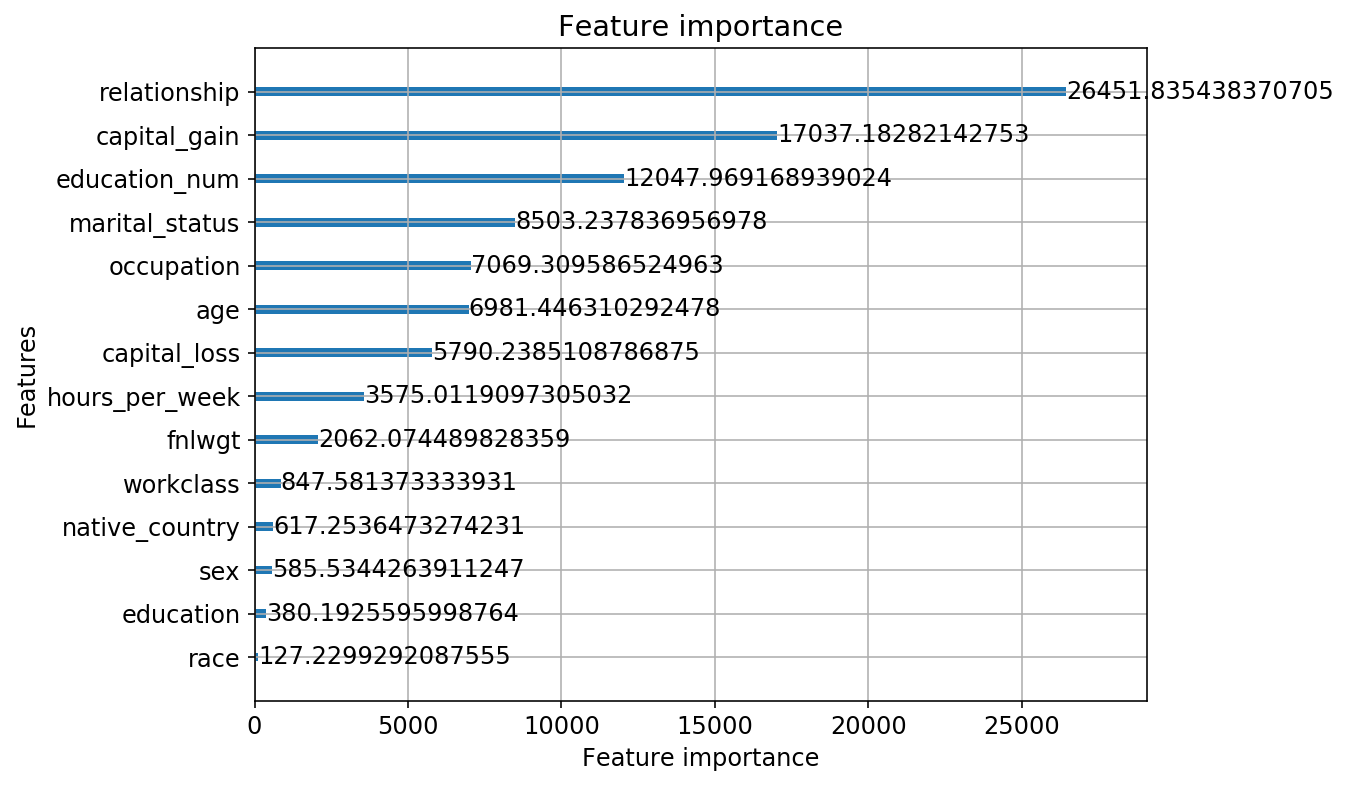

In [15]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# like other tree-based models, it can also output the
# feature importance plot
plot_importance(lgb, importance_type = 'gain')
plt.show()

For tuning LightGBM's hyperparameter, the documentation page has some pretty good suggestions. [LightGBM Documentation: Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

# Reference

- [LightGBM Documentation: Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [Blog: xgboost’s New Fast Histogram (tree_method = hist)](https://medium.com/data-design/xgboosts-new-fast-histogram-tree-method-hist-a3c08f36234c)
- [Blog: Which algorithm takes the crown: Light GBM vs XGBOOST?](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)
- [Blog: Are categorical variables getting lost in your random forests?](http://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Blog: Lessons Learned From Benchmarking Fast Machine Learning Algorithms](https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/)
- [Stackoverflow: Why tree-based model do not need one-hot encoding for nominal data?
](https://stackoverflow.com/questions/45139834/why-tree-based-model-do-not-need-one-hot-encoding-for-nominal-data)